# Household Energy Consumption

**Introduction:**

The aim of this notebook is to explore the large dataset, deal with missig values & replace them adequately, make a good exploration of the data and **forecast future energy consumption** with Time Series approach.

The dataset contains information about energy consumption of a family house located in Northen France, for a period of 47 months.

**Data Set Information:**

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 
Notes: 
1. **(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)** represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 

2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


**Attribute Information:**

1. **date**: Date in format dd/mm/yyyy 
2. **time**: time in format hh:mm:ss 
3. **global_active_power**: household global minute-averaged active power (in kilowatt) 
4. **global_reactive_power**: household global minute-averaged reactive power (in kilowatt) 
5. **voltage**: minute-averaged voltage (in volt) 
6. **global_intensity**: household global minute-averaged current intensity (in ampere) 
7. **sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
8. **sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
9. **sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



# Data Exploration

## Import relevant modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

from numpy import nan as NA
from pandas import read_csv
from pandas.tools.plotting import autocorrelation_plot

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import calmap
import datetime
from math import sqrt
from pyramid.arima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Load Raw Dataset

In [351]:
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, 
                   low_memory=False, infer_datetime_format=True, 
                   parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [352]:
# summarize
print(dataset.shape)
print(dataset.head())

(2075259, 7)
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.

## Replace '?' values with NA

In [353]:
dataset.replace('?', NA, inplace=True)

## Add new metrics

In [354]:
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

## Write dataset as .csv & re-upload

In [355]:
# save updated dataset
#dataset.to_csv('household_power_consumption.csv')

In [356]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
print(dataset.head())

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

# Initial Data Exploration

## General overview of variables

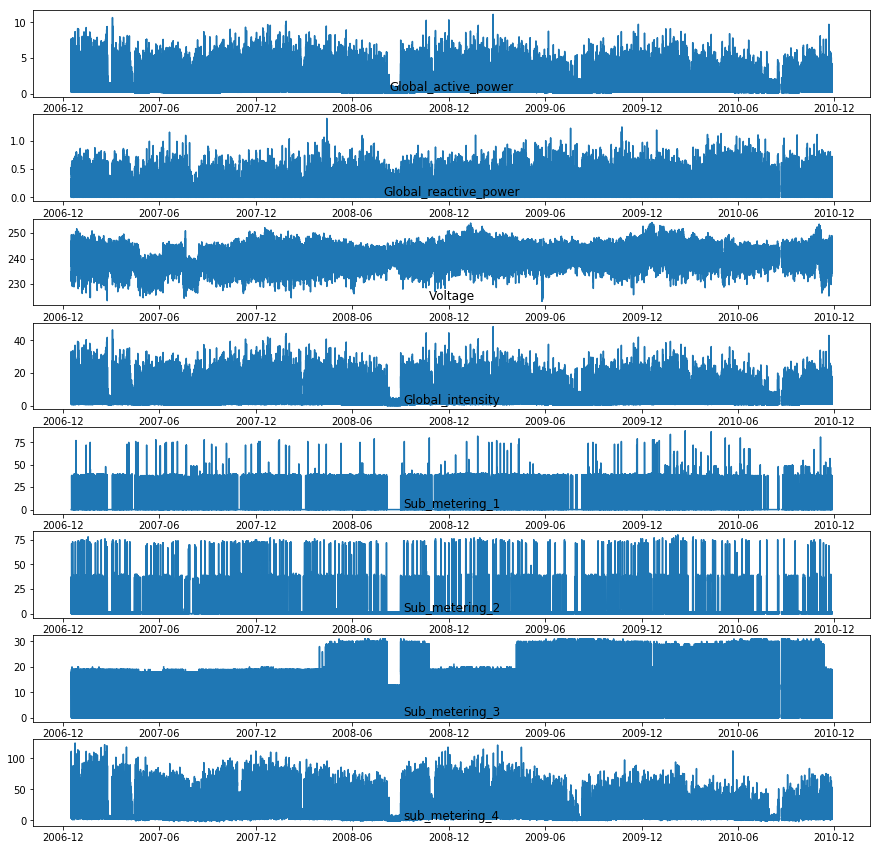

In [357]:
# line plot for each variable
pyplot.figure(figsize=(15,15))
for i in range(len(dataset.columns)):
    pyplot.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    pyplot.plot(dataset[name])
    pyplot.title(name, y=0)
pyplot.show()

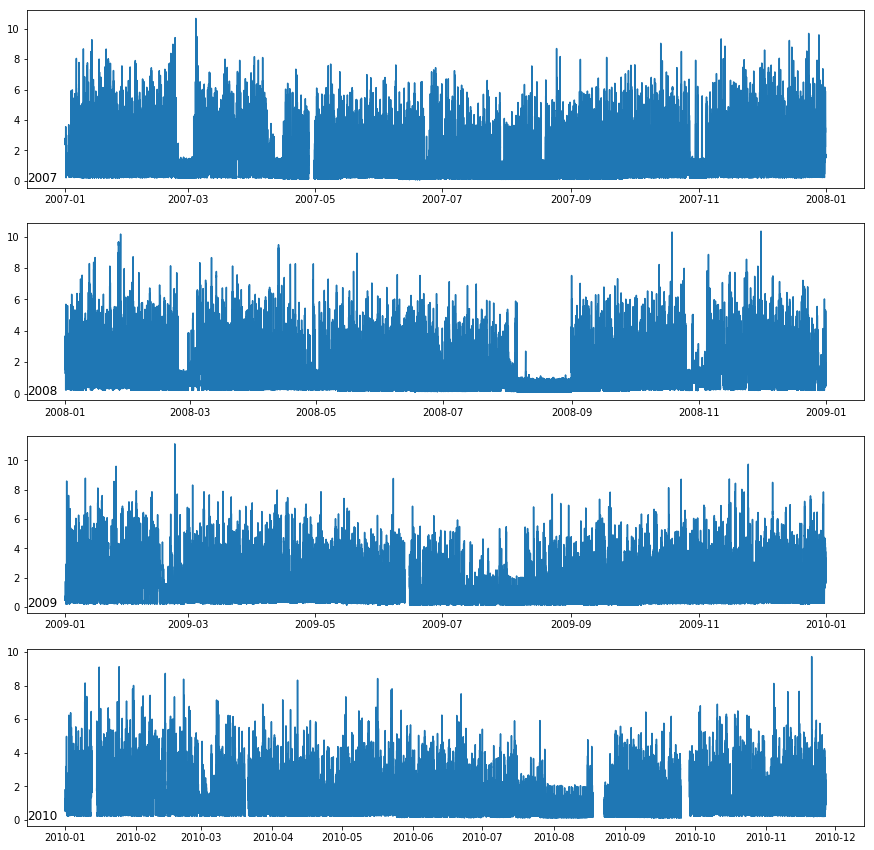

In [358]:
# plot active power for each year
years = ['2007', '2008', '2009', '2010']
pyplot.figure(figsize=(15,15))
for i in range(len(years)):
    ax = pyplot.subplot(len(years), 1, i+1)
    year = years[i]
    result = dataset[str(year)]
    pyplot.plot(result['Global_active_power'])
    pyplot.title(str(year), y=0, loc='left')
pyplot.show()

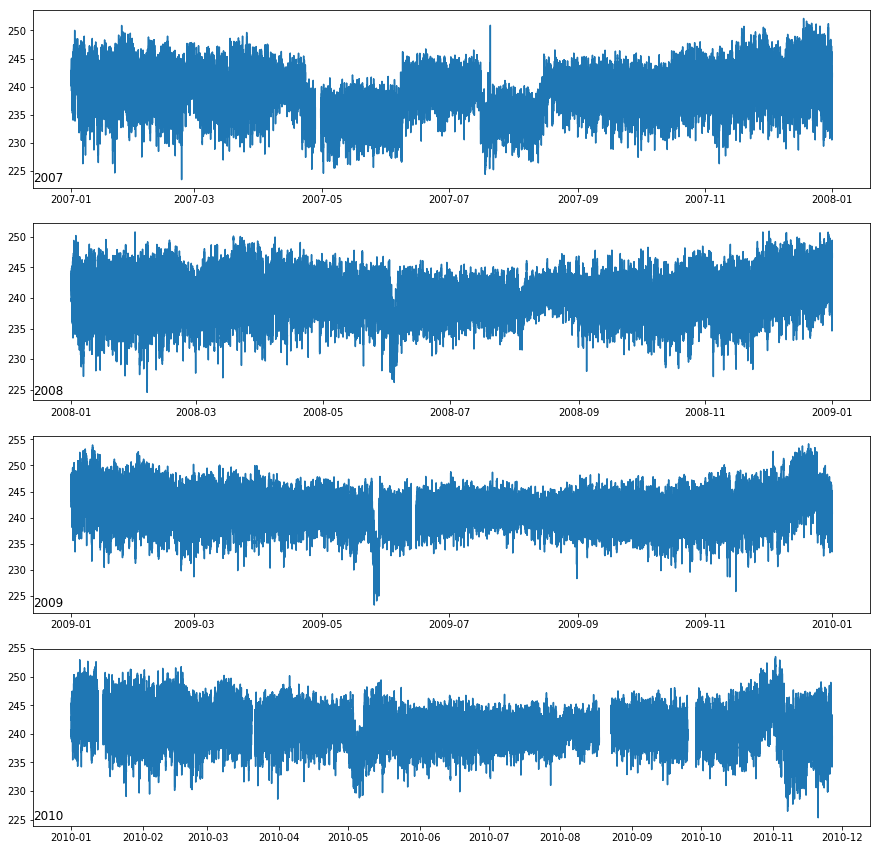

In [359]:
# plot voltage for each year
years = ['2007', '2008', '2009', '2010']
pyplot.figure(figsize=(15,15))
for i in range(len(years)):
    ax = pyplot.subplot(len(years), 1, i+1)
    year = years[i]
    result = dataset[str(year)]
    pyplot.plot(result['Voltage'])
    pyplot.title(str(year), y=0, loc='left')
pyplot.show()

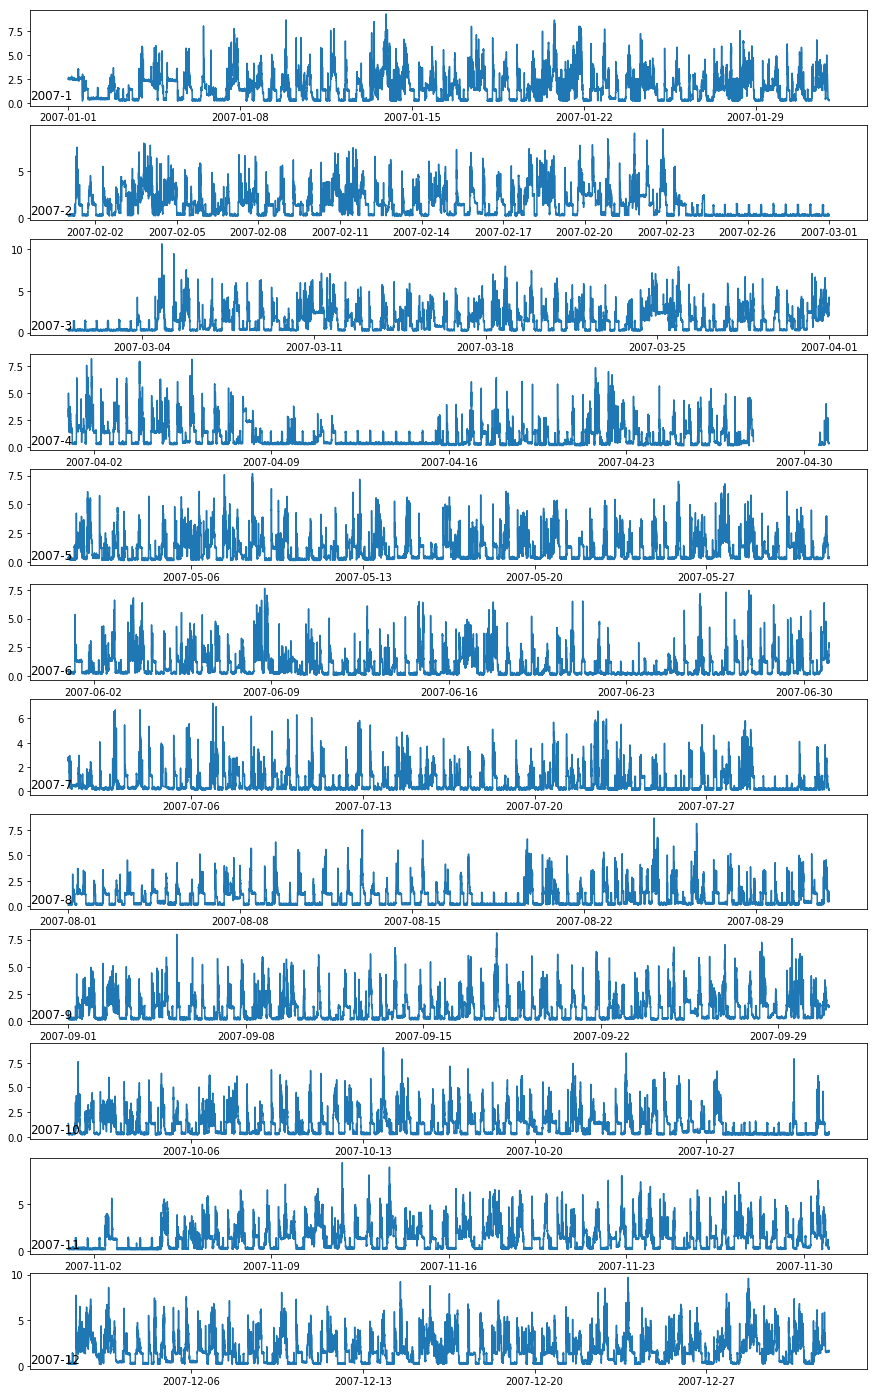

In [360]:
# plot active power in a given year
months = [x for x in range(1, 13)]
pyplot.figure(figsize=(15,25))
for i in range(len(months)):
    ax = pyplot.subplot(len(months), 1, i+1)
    month = '2007-' + str(months[i])
    result = dataset[month]
    pyplot.plot(result['Global_active_power'])
    pyplot.title(month, y=0, loc='left')
pyplot.show()

## Variable distribution

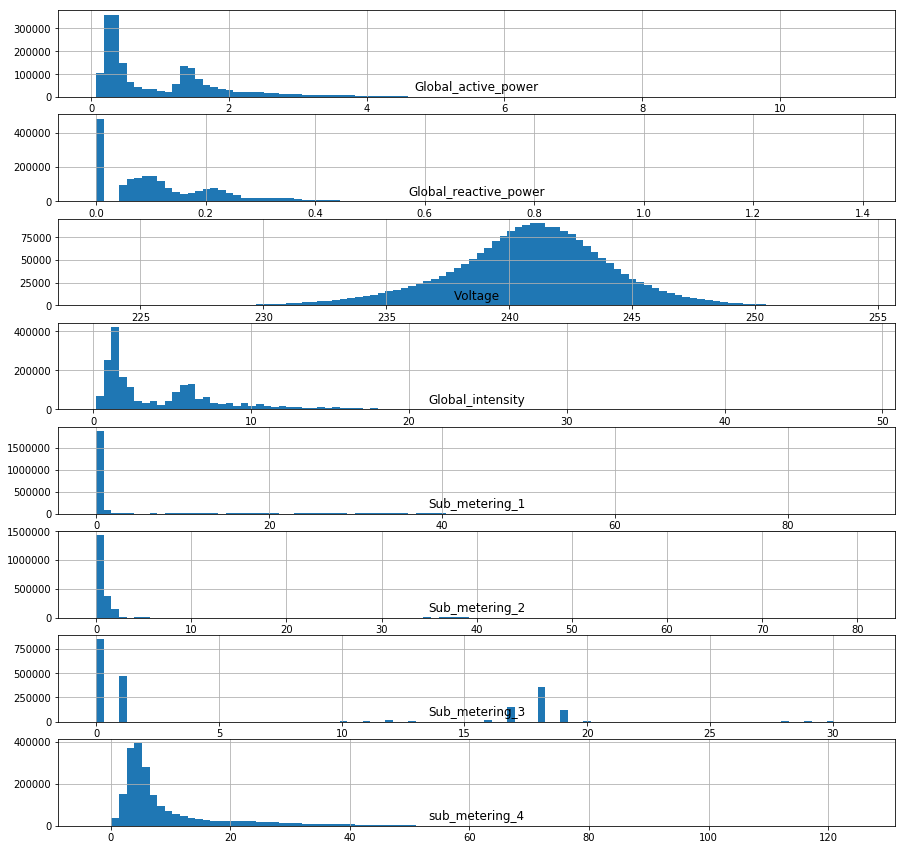

In [361]:
# histogram plot for each variable
pyplot.figure(figsize=(15,15))
for i in range(len(dataset.columns)):
    pyplot.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    dataset[name].hist(bins=100)
    pyplot.title(name, y=0)
pyplot.show()

## Explore dataset without NAs

In [362]:
clean_df = dataset.dropna(axis=0,how='any')

In [363]:
clean_df.head()

Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  sub_metering_4  
datetime                                             
2006-12-16 17:24:00            17.0       52.266670  
2006-12-16 17:25:00            16.0       72.333336  
2006-12-16 17:26:00            17.0       70.566666  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000

In [364]:
x = clean_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.index = clean_df.index
df.columns = clean_df.columns

In [365]:
df.head()

Global_active_power  Global_reactive_power   Voltage  \
datetime                                                                    
2006-12-16 17:24:00             0.374796               0.300719  0.376090   
2006-12-16 17:25:00             0.478363               0.313669  0.336995   
2006-12-16 17:26:00             0.479631               0.358273  0.326010   
2006-12-16 17:27:00             0.480898               0.361151  0.340549   
2006-12-16 17:28:00             0.325005               0.379856  0.403231   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00          0.377593             0.0          0.0125   
2006-12-16 17:25:00          0.473029             0.0          0.0125   
2006-12-16 17:26:00          0.473029             0.0          0.0250   
2006-12-16 17:27:00          0.473029             0.0          0.0125   
2006-12-16 17:28:00          0.323651             0.0          0.0125   

                     Sub_metering_3  sub_metering_4  
datetime                                             
2006-12-16 17:24:00        0.548387        0.429657  
2006-12-16 17:25:00        0.516129        0.587372  
2006-12-16 17:26:00        0.548387        0.573487  
2006-12-16 17:27:00        0.548387        0.583181  
2006-12-16 17:28:00        0.548387        0.357611

### Plot relevant variables for specific date ranges

#### One day every trimester for a year 

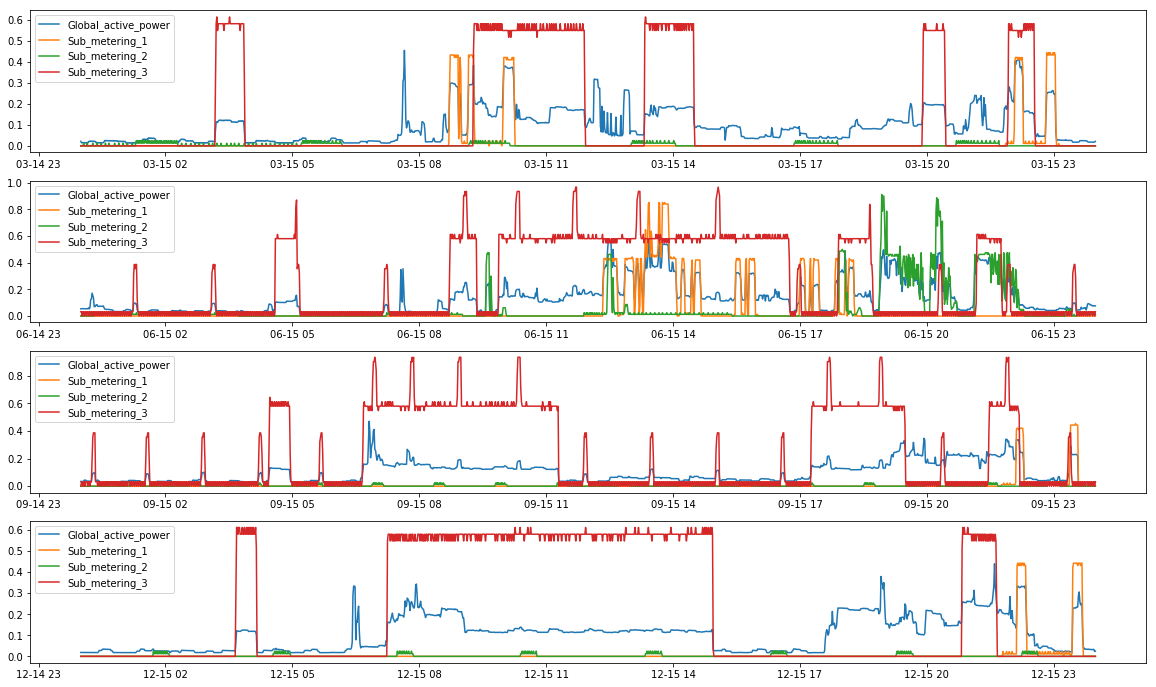

In [366]:
#Plot a day in march, june, sept, december of 2008
pyplot.figure(figsize=(20,12))
months = ['03', '06', '09', '12']
variables = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']

for i,j in zip(range(4), months):
    for k in variables:
        pyplot.subplot(4,1, i+1)
        pyplot.plot(df['2008-'+ j +'-15'][k])
        pyplot.legend(loc=2)

#### Christmas day every year

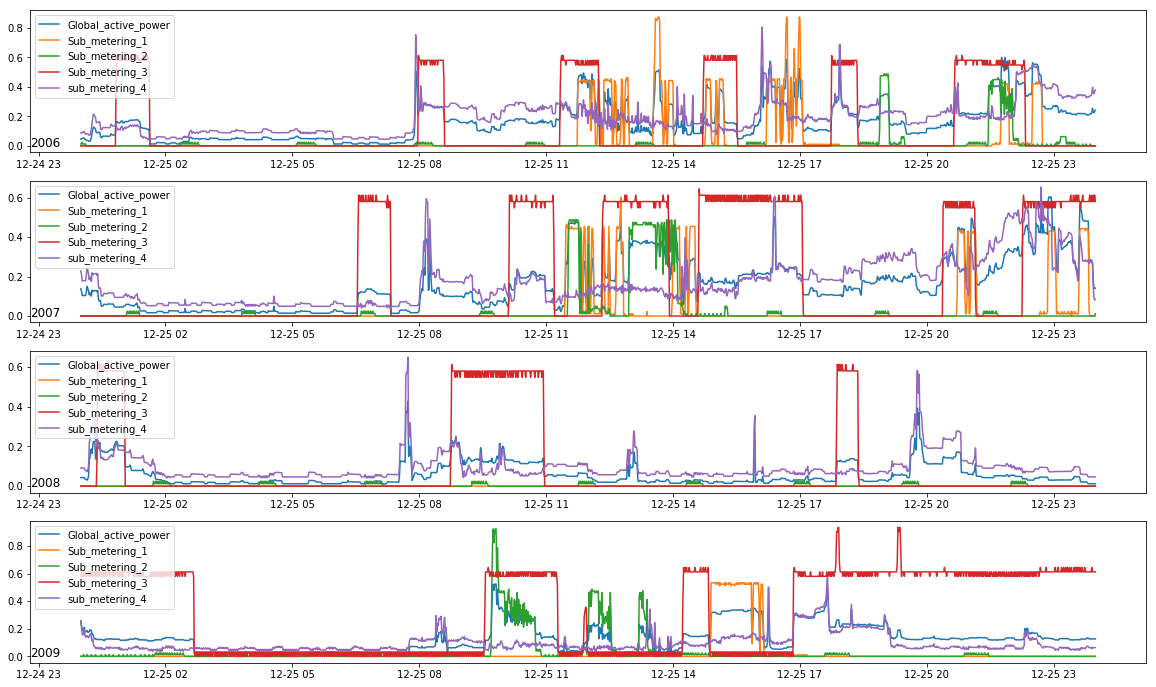

In [367]:
# plot Christmas for each year
years = ['2006', '2007', '2008', '2009']
variables = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3', 'sub_metering_4']
pyplot.figure(figsize=(20,12))
for i in range(len(years)):
    for j in variables:
        pyplot.subplot(len(years), 1, i+1)
        pyplot.plot(df[years[i] + '-12-25'][j])
        pyplot.title(years[i], y=0, loc='left')
        pyplot.legend(loc=2)

#### Two days after Christmas, every year

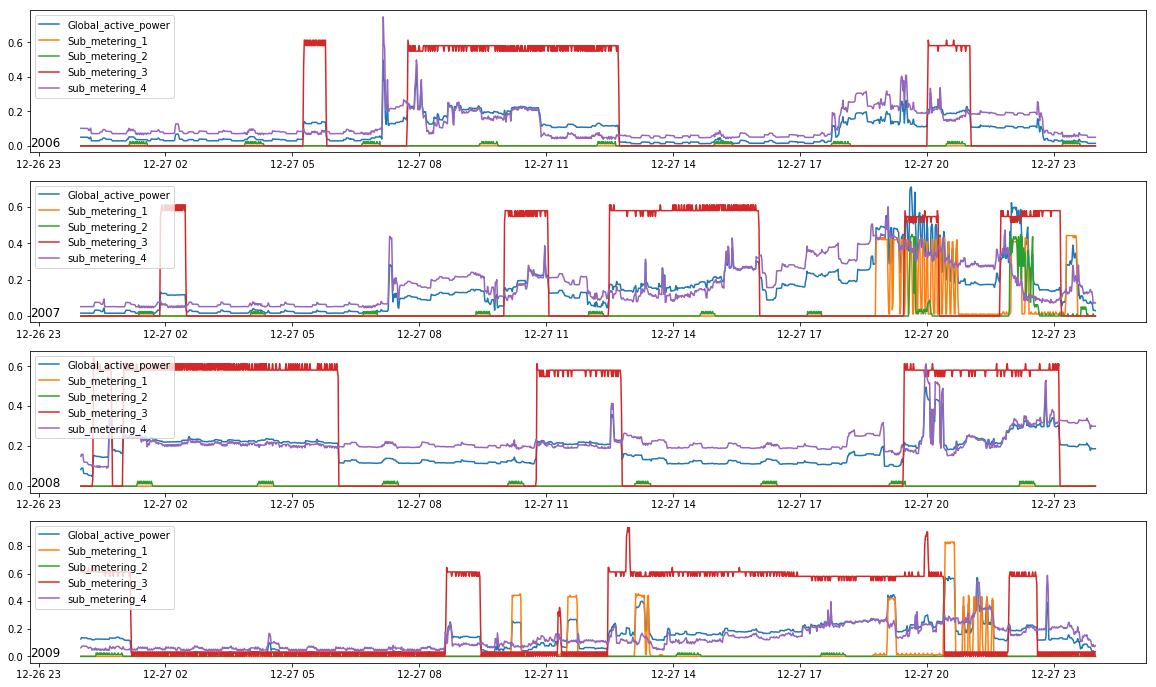

In [368]:
# plot two days after Christmas for each year
years = ['2006', '2007', '2008', '2009']
variables = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3', 'sub_metering_4']
pyplot.figure(figsize=(20,12))
for i in range(len(years)):
    for j in variables:
        pyplot.subplot(len(years), 1, i+1)
        pyplot.plot(df[years[i] + '-12-27'][j])
        pyplot.title(years[i], y=0, loc='left')
        pyplot.legend(loc=2)

#### France National Day, every year

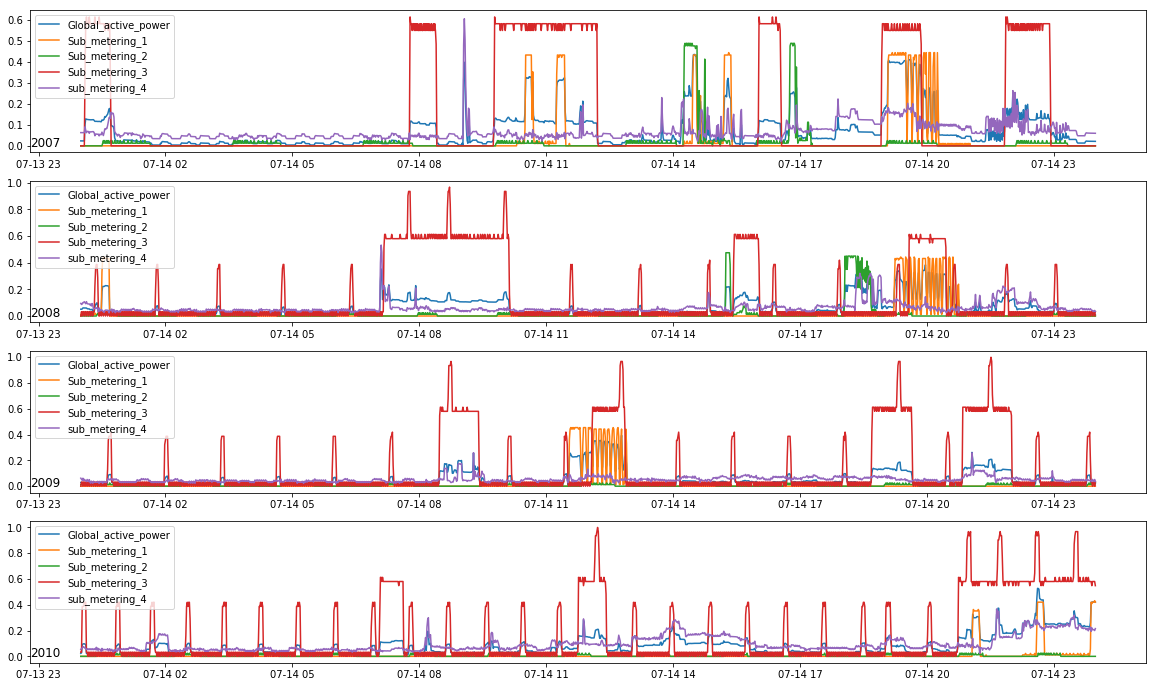

In [369]:
# plot 14th july Bastille day for each year
years = ['2007', '2008', '2009', '2010']
variables = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3', 'sub_metering_4']
pyplot.figure(figsize=(20,12))
for i in range(len(years)):
    for j in variables:
        pyplot.subplot(len(years), 1, i+1)
        pyplot.plot(df[years[i] + '-07-14'][j])
        pyplot.title(years[i], y=0, loc='left')
        pyplot.legend(loc=2)

## Resample data in relevant granularity

In [370]:
day_mean_df = dataset.resample('D').mean()
week_mean_df = dataset.resample('W').mean()
month_mean_df = dataset.resample('M').mean()

df = [day_mean_df, week_mean_df, month_mean_df]


## Explore data by days, weeks and months

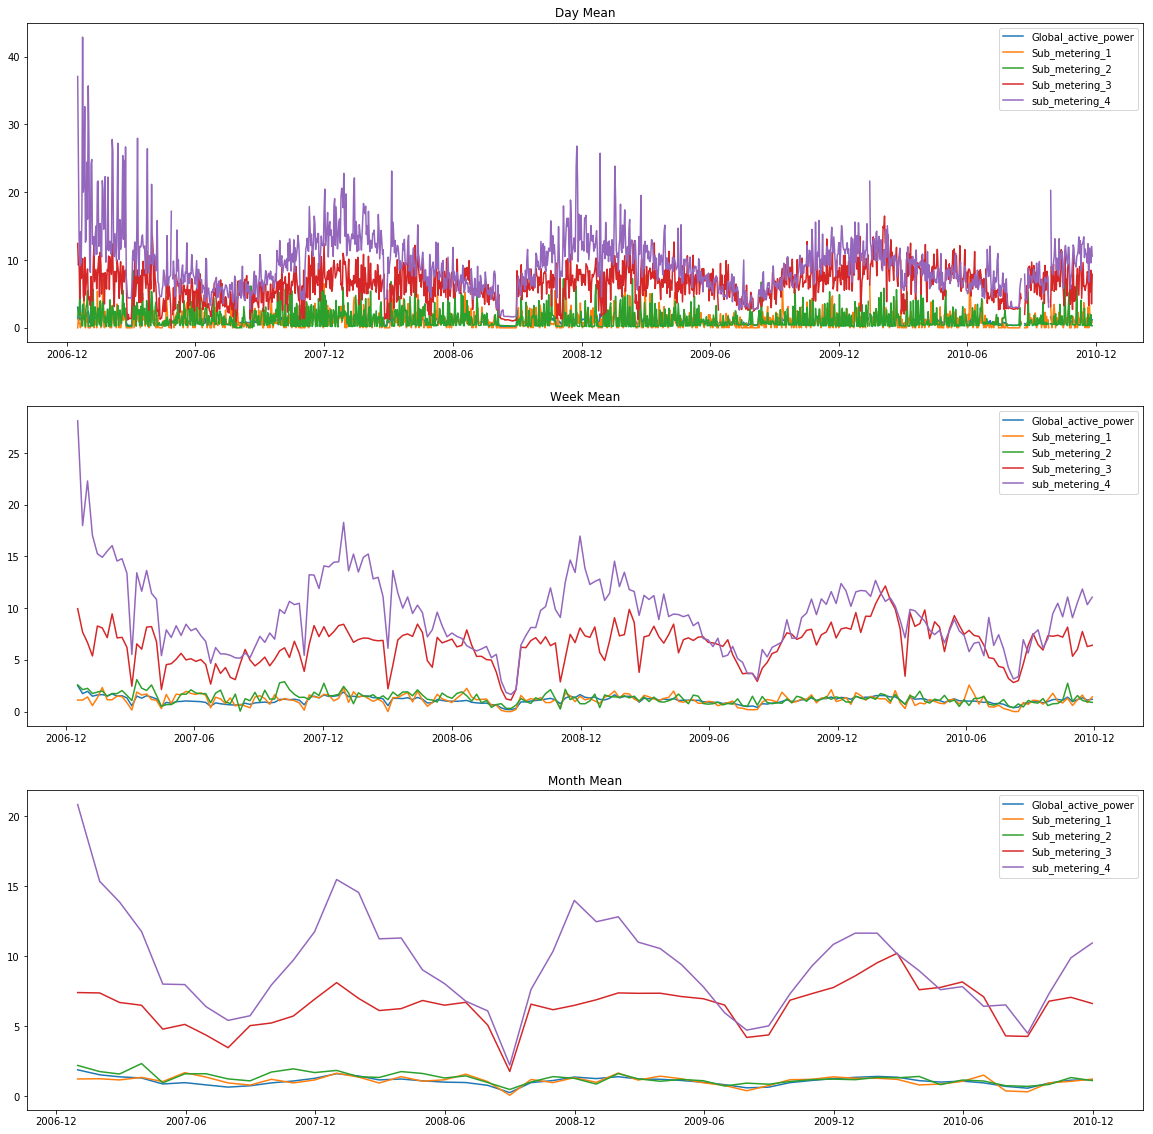

In [371]:
pyplot.figure(figsize=(20,20))
for i in range(len(df)):
    pyplot.subplot(len(df),1,i+1)
    df_names = ['Day Mean', 'Week Mean', 'Month Mean']
    pyplot.title(df_names[i])
    dataframe = df[i]
    names = []
    for j in [0,4,5,6,7]:
        pyplot.plot(dataframe.iloc[:,[j]])
        names.append(dataset.columns[j])
        pyplot.legend(names)

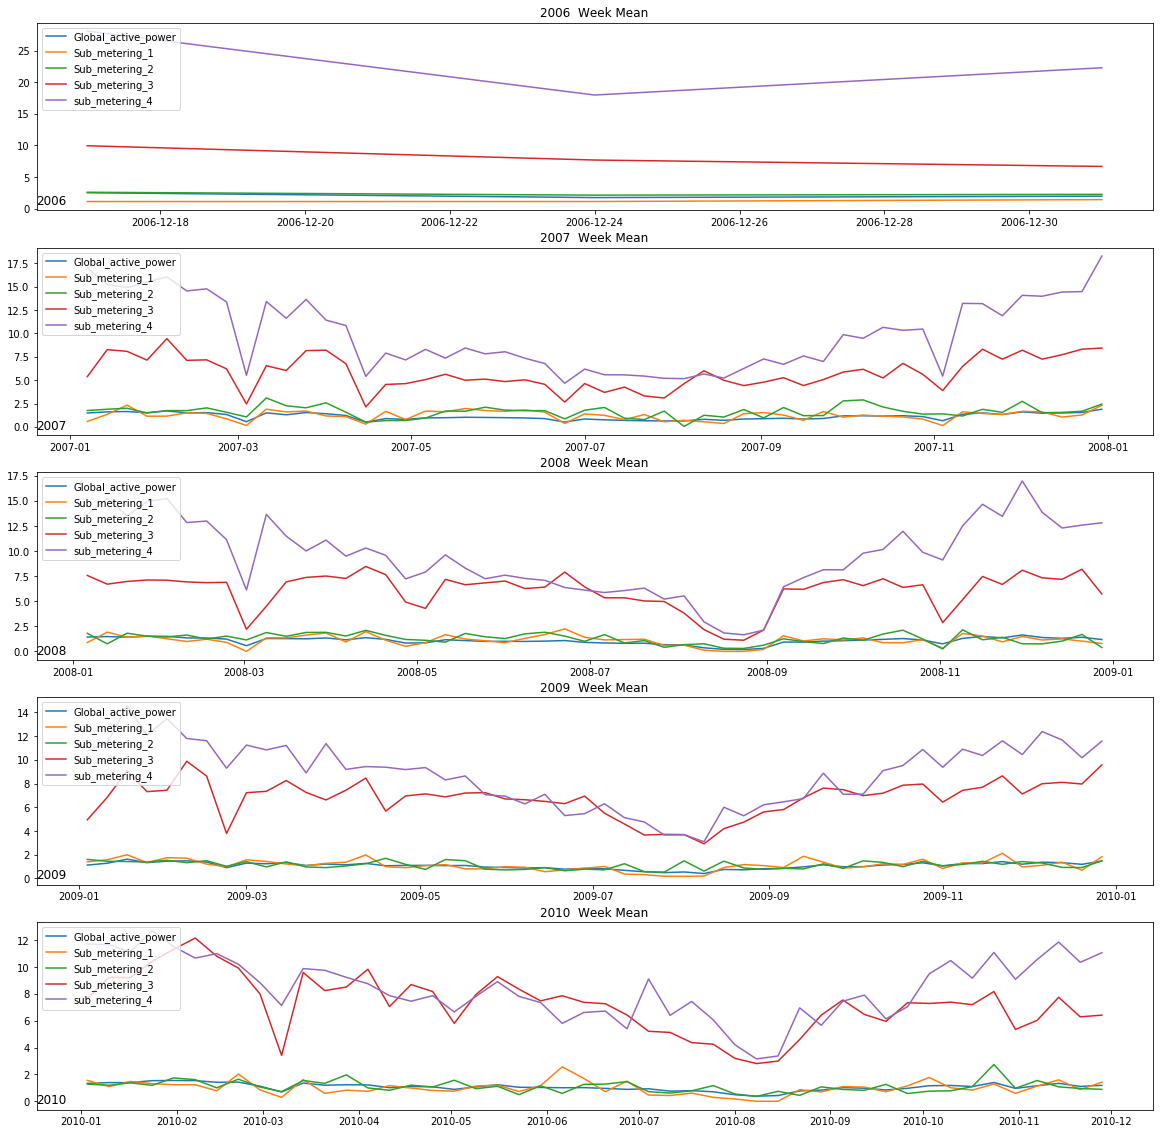

In [372]:
years = ['2006', '2007', '2008', '2009', '2010']
pyplot.figure(figsize=(20,20))
for i in range(len(years)):
    pyplot.subplot(len(years), 1, i+1)
    pyplot.title(years[i] + '  Week Mean')
    year = years[int(i)]
    result = week_mean_df[year]
    names = []
    pyplot.title(years[i], y=0, loc='left')
    for j in [0,4,5,6,7]:
        pyplot.plot(result.iloc[:,[j]])
        names.append(result.columns[j])
        pyplot.legend(names, loc=2)

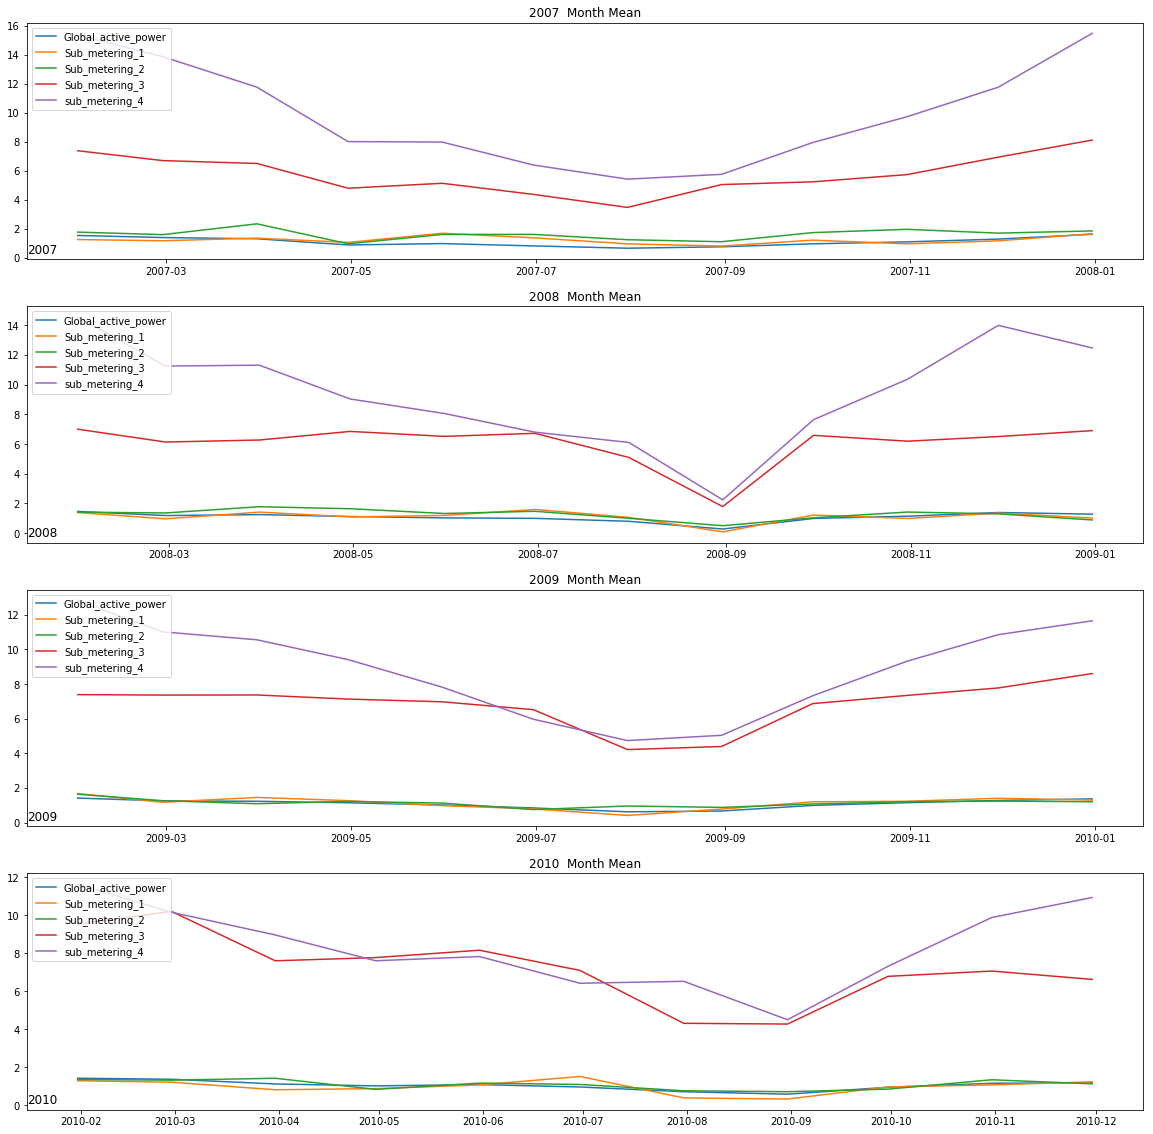

In [373]:
years = ['2007', '2008', '2009', '2010']
pyplot.figure(figsize=(20,20))
for i in range(len(years)):
    pyplot.subplot(len(years), 1, i+1)
    pyplot.title(years[i] + '  Month Mean')
    year = years[i]
    result = month_mean_df[year]
    names = []
    pyplot.title(years[i], y=0, loc='left')
    for j in [0,4,5,6,7]:
        pyplot.plot(result.iloc[:,[j]])
        names.append(result.columns[j])
        pyplot.legend(names, loc=2)

# Deal with NAs & replacing them

In [374]:
dataset.isna().values.any()

True

In [375]:
na_10 = pd.DataFrame(dataset['Global_active_power'].isna().map({False:0, True:1}))

In [376]:
na_10.head()

Global_active_power
datetime                                
2006-12-16 17:24:00                    0
2006-12-16 17:25:00                    0
2006-12-16 17:26:00                    0
2006-12-16 17:27:00                    0
2006-12-16 17:28:00                    0

### NAs occurrence in time

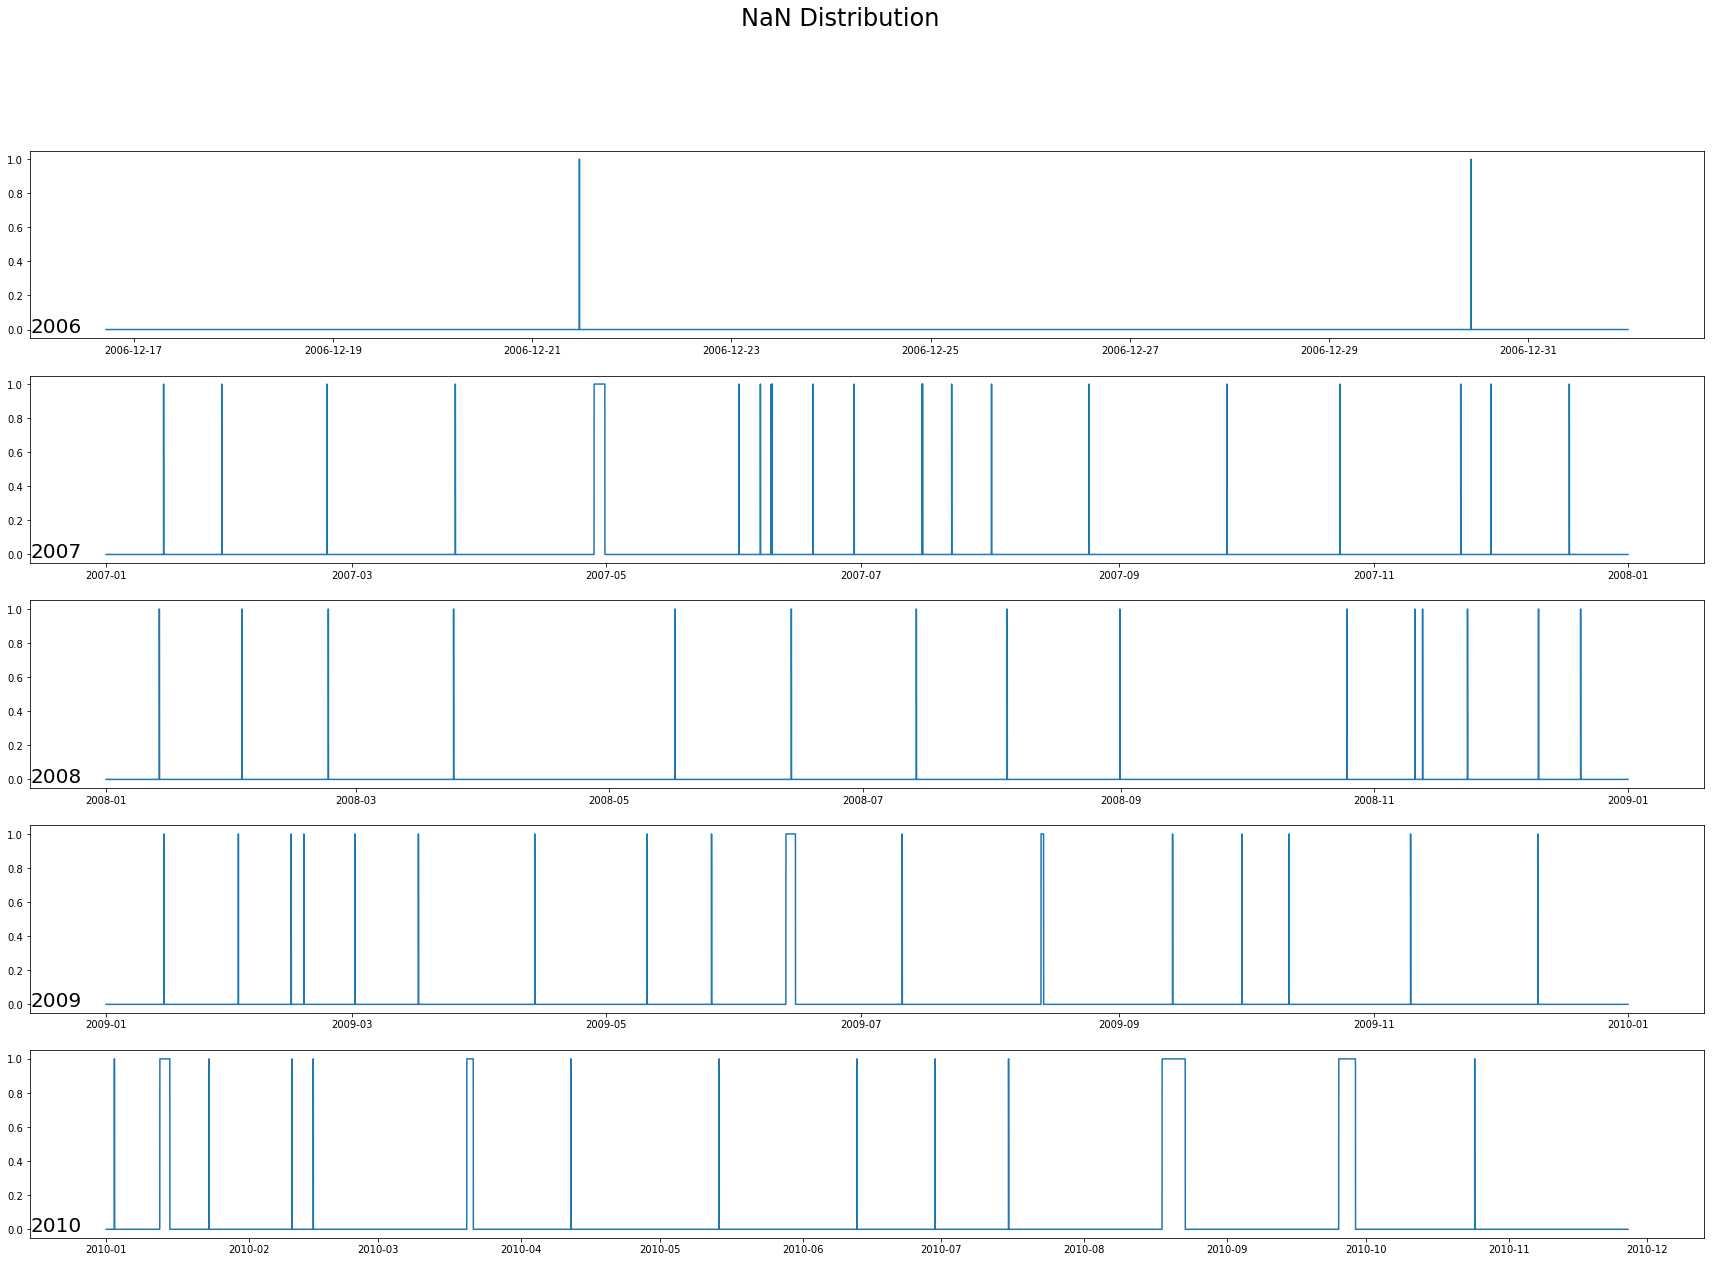

In [377]:
pyplot.figure(figsize=(30,20))
pyplot.suptitle('NaN Distribution', fontsize=24)
years = ['2006','2007', '2008', '2009', '2010']
for i in range(len(years)):
    pyplot.subplot(len(years), 1, i+1)
    pyplot.title(years[i], y=0, loc='left', fontsize=20)
    pyplot.plot(na_10[years[i]])

In [379]:
na_sum = na_10.resample('D').sum()
#na_sum['sum_log'] = np.log(na_sum.Global_active_power)
na_sum['sum_div'] = na_sum.Global_active_power/500

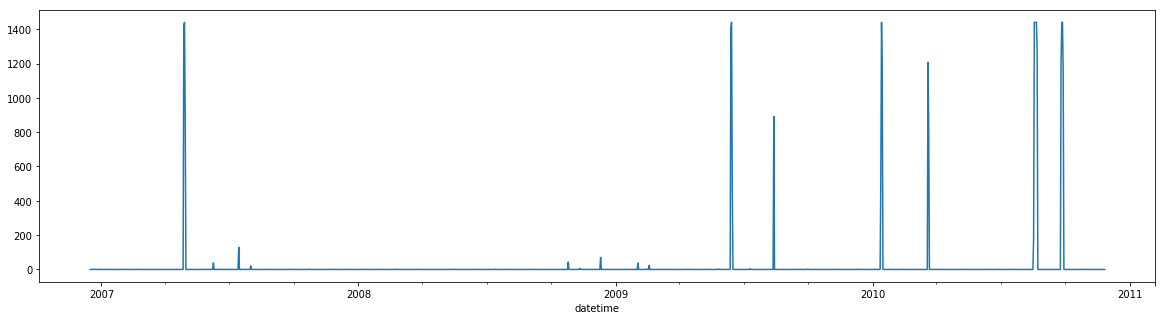

In [380]:
pyplot.figure(figsize=(20,5))
na_sum.Global_active_power.plot()

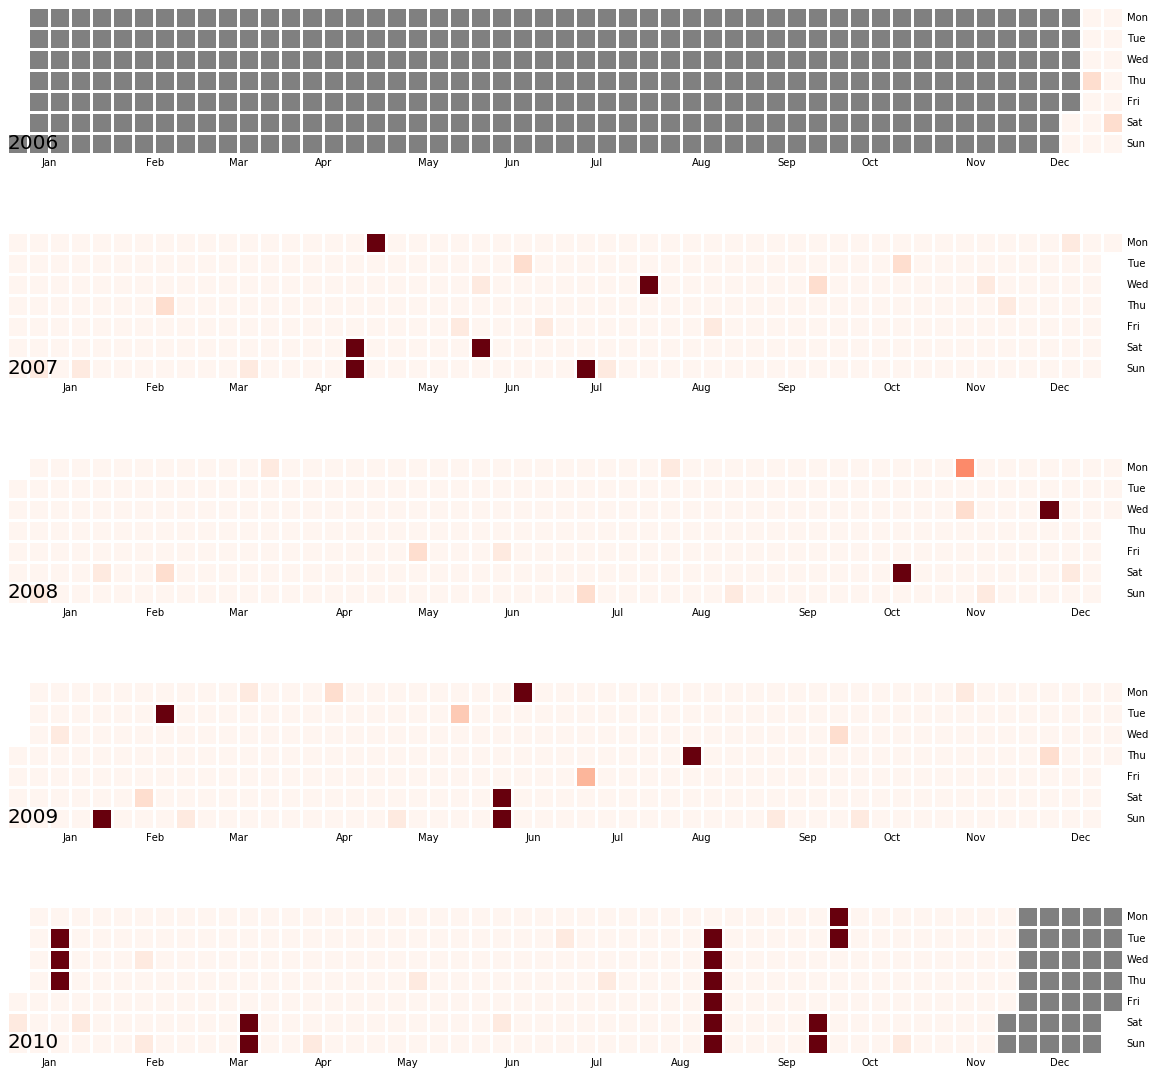

In [381]:
pyplot.figure(figsize=(20,20))
years = ['2006','2007', '2008', '2009', '2010']
for i in range(len(years)):
    pyplot.subplot(5,1,i+1)
    pyplot.title(years[i], y=0, loc='left', fontsize=20)
    calmap.yearplot(na_sum.sum_div, year=int(years[i]), vmax=.03, vmin=0, 
                    fillcolor='grey', linewidth=2, cmap='Reds')

### Replace NAs with an educated guess

In [383]:
dataset[dataset.isnull().any(axis=1)].head()

Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-21 11:23:00               NaN             NaN             NaN   
2006-12-21 11:24:00               NaN             NaN             NaN   
2006-12-30 10:08:00               NaN             NaN             NaN   
2006-12-30 10:09:00               NaN             NaN             NaN   
2007-01-14 18:36:00               NaN             NaN             NaN   

                     Sub_metering_3  sub_metering_4  
datetime                                             
2006-12-21 11:23:00             NaN             NaN  
2006-12-21 11:24:00             NaN             NaN  
2006-12-30 10:08:00             NaN             NaN  
2006-12-30 10:09:00             NaN             NaN  
2007-01-14 18:36:00             NaN             NaN

In [ ]:
def find_distr(df, hour, col):
    all_hour_mean = np.abs(round(df.iloc[:,col].resample('H').mean(),1))
    hist = all_hour_mean[all_hour_mean.index.hour == hour]
    #hist.hist(bins=50)
    vals = pd.value_counts(hist).index.tolist()
    freq = pd.value_counts(hist).tolist()
    prob = [i/round(sum(vals),1) for i in vals]
    pick = np.random.choice(vals, 1, p=prob)
    return float(pick)

In [384]:
def fill_missing(df):
    df1 = df.resample('H').mean()
    for row in range(df1.shape[0]):
        for col in range(df1.shape[1]):
            if np.isnan(df1.iloc[row, col]):
                hour = dataset.index[row].hour
                df1.iloc[row, col] = find_distr(df1, hour, col)
    return df1

In [385]:
try_df = dataset.iloc[:,:]

In [386]:
try_df.isna().values.any()

True

In [387]:
clean_df = fill_missing(try_df)

In [388]:
clean_df.isna().values.any()

False

In [512]:
#clean_df.to_csv('clean_household_power_consumption.csv')

### Plot NA replacement in action

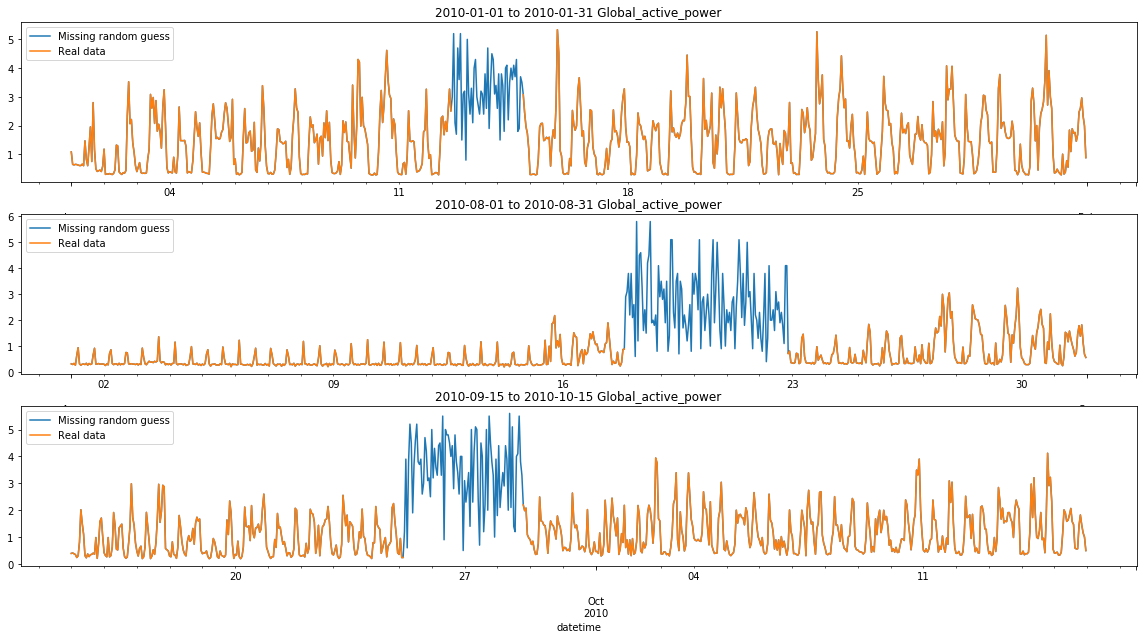

In [389]:
pyplot.figure(figsize=(20,10))
pyplot.subplot(3,1,1)
clean_df['2010-01-01':'2010-01-31']['Global_active_power'].resample('H').mean().plot()
dataset['2010-01-01':'2010-01-31']['Global_active_power'].resample('H').mean().plot()
pyplot.title('2010-01-01 to 2010-01-31 Global_active_power', y=1)
pyplot.legend(['Missing random guess', 'Real data'], loc=2)
pyplot.subplot(3,1,2)
clean_df['2010-08-01':'2010-08-31']['Global_active_power'].resample('H').mean().plot()
dataset['2010-08-01':'2010-08-31']['Global_active_power'].resample('H').mean().plot()
pyplot.title('2010-08-01 to 2010-08-31 Global_active_power', y=1)
pyplot.legend(['Missing random guess', 'Real data'], loc=2)
pyplot.subplot(3,1,3)
clean_df['2010-09-15':'2010-10-15']['Global_active_power'].resample('H').mean().plot()
dataset['2010-09-15':'2010-10-15']['Global_active_power'].resample('H').mean().plot()
pyplot.title('2010-09-15 to 2010-10-15 Global_active_power', y=1)
pyplot.legend(['Missing random guess', 'Real data'], loc=2)

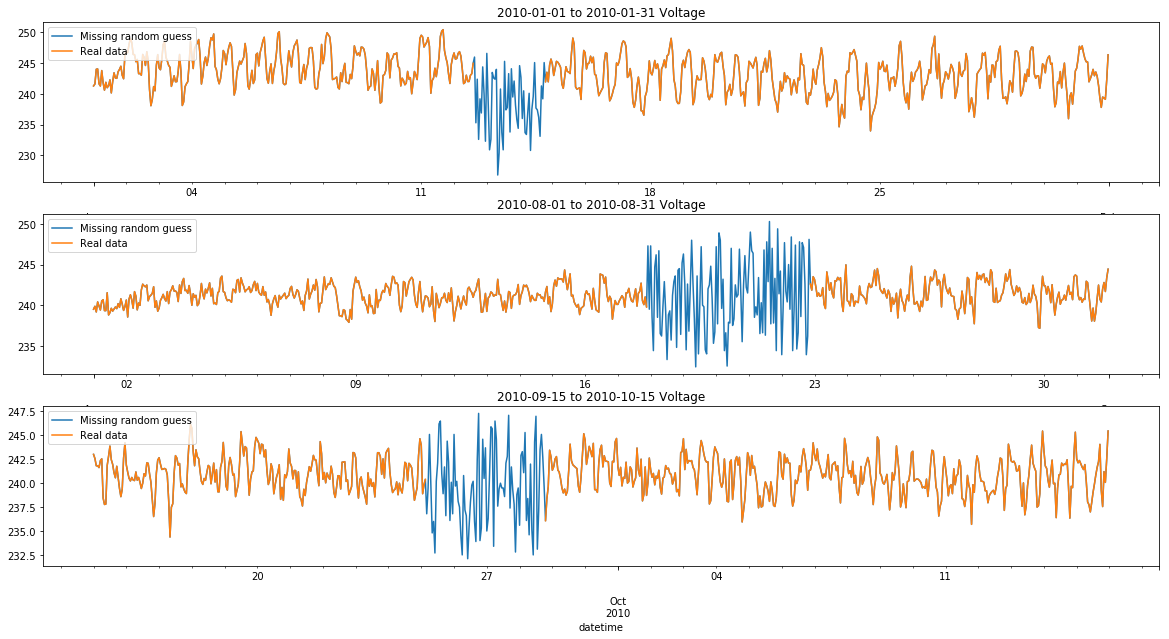

In [390]:
pyplot.figure(figsize=(20,10))
pyplot.subplot(3,1,1)
clean_df['2010-01-01':'2010-01-31']['Voltage'].resample('H').mean().plot()
dataset['2010-01-01':'2010-01-31']['Voltage'].resample('H').mean().plot()
pyplot.title('2010-01-01 to 2010-01-31 Voltage', y=1)
pyplot.legend(['Missing random guess', 'Real data'], loc=2)
pyplot.subplot(3,1,2)
clean_df['2010-08-01':'2010-08-31']['Voltage'].resample('H').mean().plot()
dataset['2010-08-01':'2010-08-31']['Voltage'].resample('H').mean().plot()
pyplot.title('2010-08-01 to 2010-08-31 Voltage', y=1)
pyplot.legend(['Missing random guess', 'Real data'], loc=2)
pyplot.subplot(3,1,3)
clean_df['2010-09-15':'2010-10-15']['Voltage'].resample('H').mean().plot()
dataset['2010-09-15':'2010-10-15']['Voltage'].resample('H').mean().plot()
pyplot.title('2010-09-15 to 2010-10-15 Voltage', y=1)
pyplot.legend(['Missing random guess', 'Real data'], loc=2)

# Time Series Preparation

In [391]:
ts_week = clean_df['Global_active_power'].resample('W').mean()
ts_month = clean_df['Global_active_power'].resample('M').mean()

In [392]:
ts_week['2006']

datetime
2006-12-17    2.527411
2006-12-24    1.733948
2006-12-31    1.958913
Freq: W-SUN, Name: Global_active_power, dtype: float64

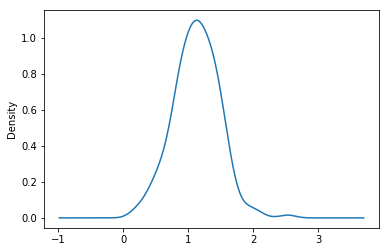

In [393]:
ts_week.plot(kind='kde')

## Plot cleaned Time Series

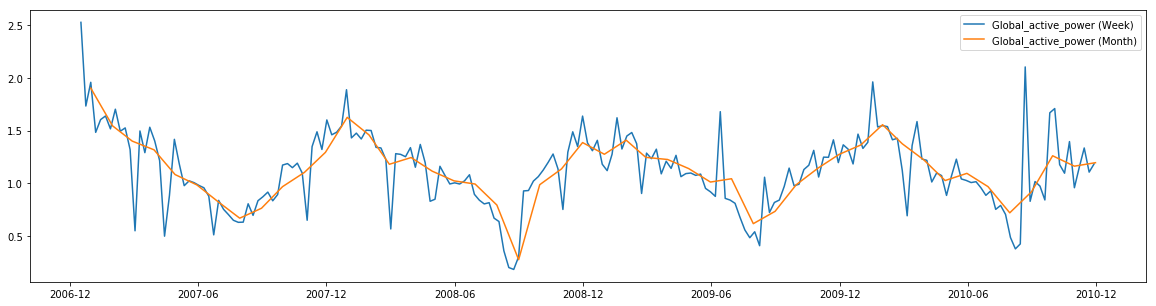

In [394]:
pyplot.figure(figsize=(20,5))
pyplot.plot(ts_week)
pyplot.plot(ts_month)
pyplot.legend(['Global_active_power (Week)', 'Global_active_power (Month)'], loc=1)


## Basic Time Series Statistical Tests

### Stationarity Tests

In [396]:
def test_stationarity(timeseries):
    pyplot.figure(figsize=(20,5))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue',label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label = 'Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

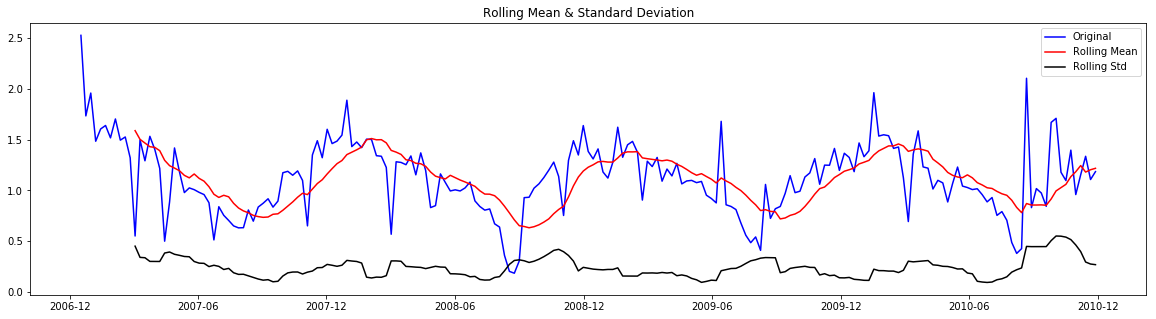

Results of Dickey-Fuller Test:
Test Statistic                  -4.558292
p-value                          0.000154
#Lags Used                       2.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


In [397]:
test_stationarity(ts_week)

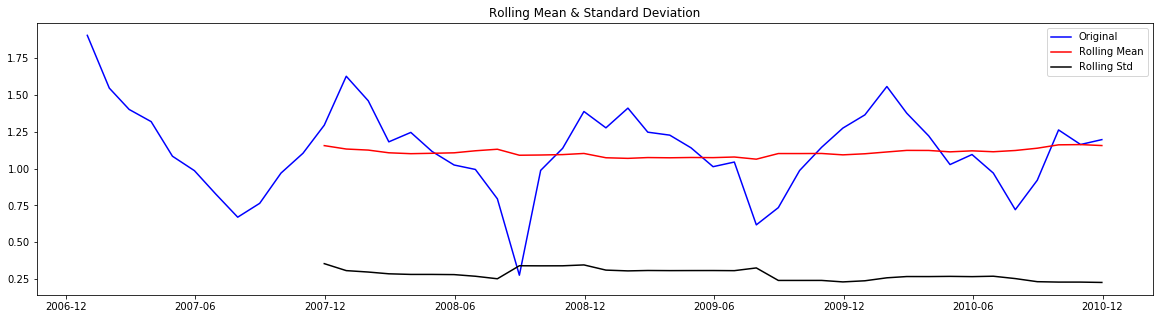

Results of Dickey-Fuller Test:
Test Statistic                 -2.214993
p-value                         0.200849
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [398]:
test_stationarity(ts_month)

### Time Series Decomposition

In [400]:
def decomposition(timeseries):
    
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    pyplot.figure(figsize=(15,8))
    pyplot.subplot(4,1,1)
    pyplot.plot(timeseries, label='Original')
    pyplot.legend(loc=1)
    pyplot.subplot(4,1,2)
    pyplot.plot(trend, label='Trend')
    pyplot.legend(loc=1)
    pyplot.subplot(4,1,3)
    pyplot.plot(seasonal,label='Seasonality')
    pyplot.legend(loc=1)
    pyplot.subplot(4,1,4)
    pyplot.plot(residual, label='Residuals')
    pyplot.legend(loc=1)
    pyplot.tight_layout()

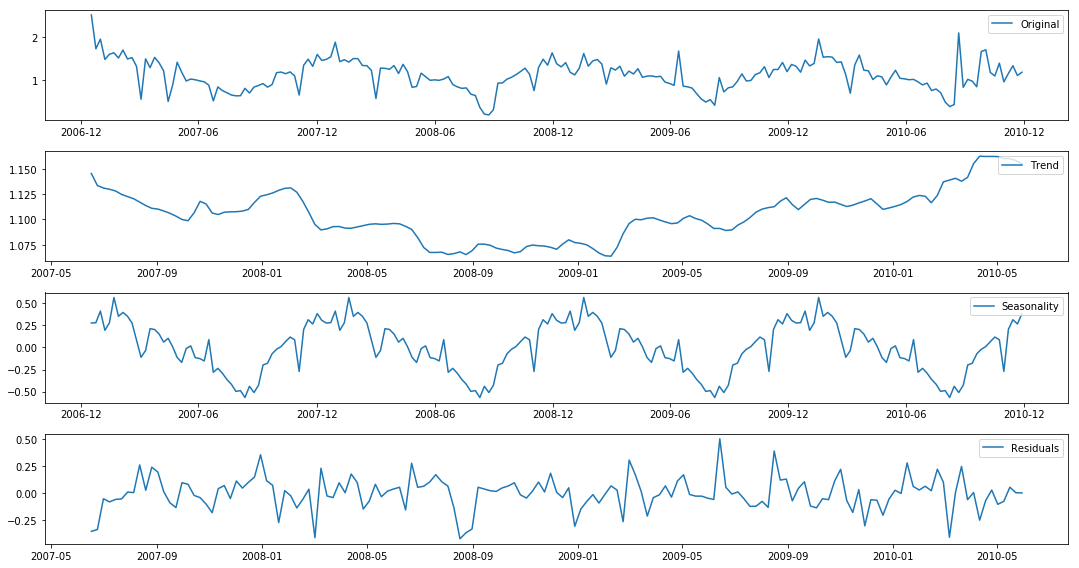

In [401]:
decomposition(ts_week)

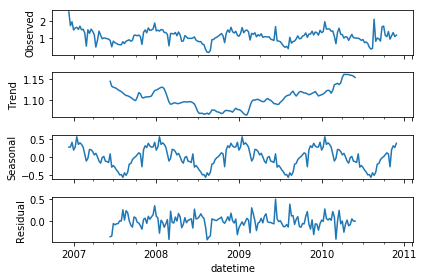

In [402]:
v = sm.tsa.seasonal_decompose(ts_week)
v.plot()
result = sm.tsa.stattools.adfuller(ts_week)
pyplot.show()

In [403]:
substracted = ts_week - v.seasonal

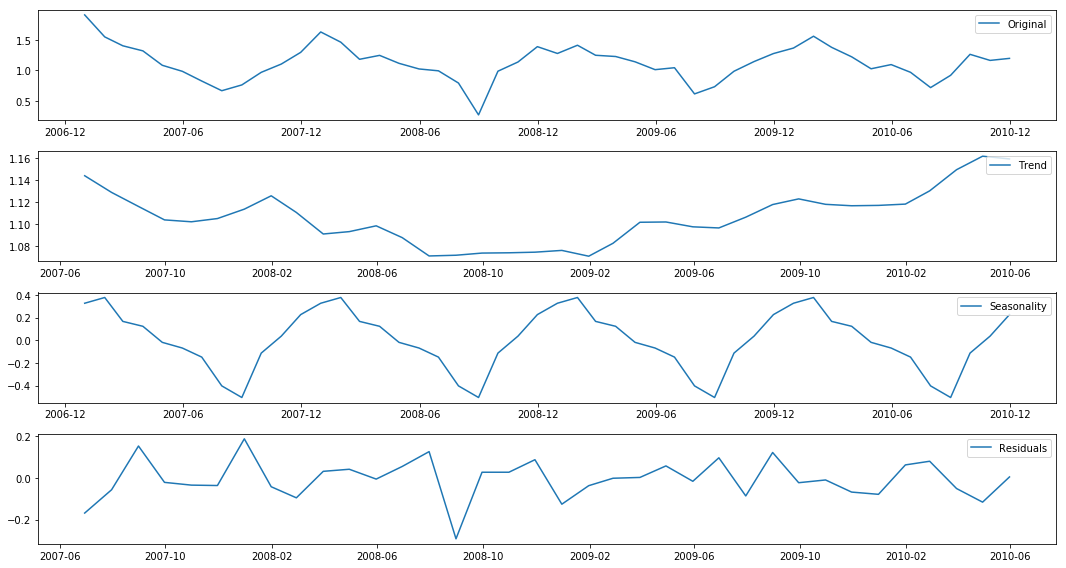

In [404]:
decomposition(ts_month)

### Autocorrelation Plots

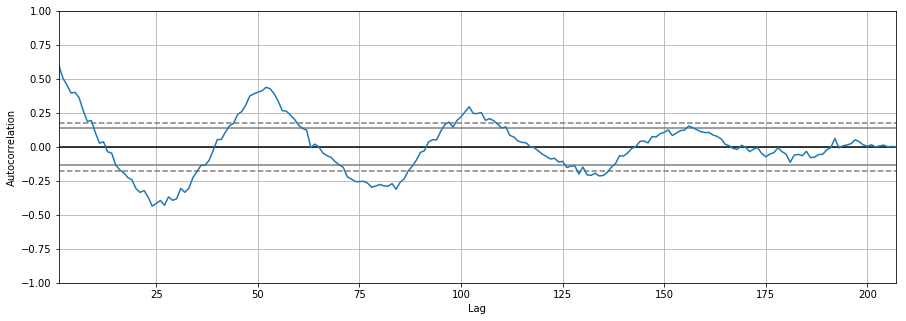

In [406]:
pyplot.figure(figsize=(15,5))
autocorrelation_plot(ts_week)

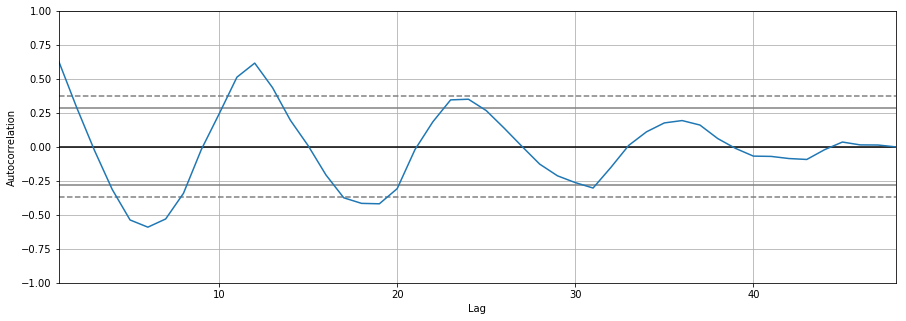

In [407]:
pyplot.figure(figsize=(15,5))
autocorrelation_plot(ts_month)

# Time Series Model Training

## Auto-ARIMA

Observations: 207
Training Observations: 144
Testing Observations: 63
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 52); AIC=39.337, BIC=44.380, Fit time=0.682 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 52); AIC=31.079, BIC=41.166, Fit time=3.844 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 52); AIC=32.158, BIC=39.723, Fit time=0.614 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 52); AIC=36.714, BIC=44.279, Fit time=2.557 seconds
Fit ARIMA: order=(2, 0, 0) seasona

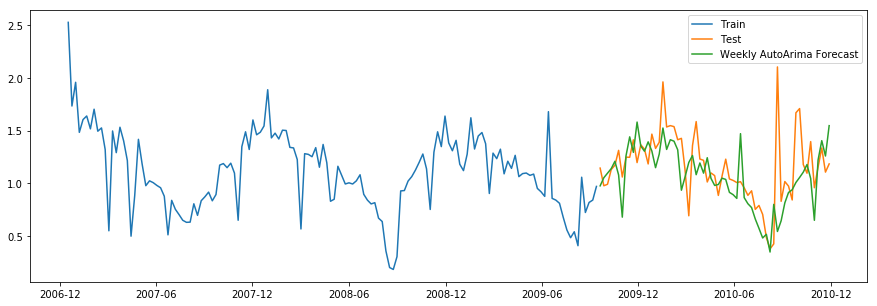

RMSE 0.310421
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 52)   Log Likelihood                 -11.539
Date:                            Tue, 26 Mar 2019   AIC                             31.079
Time:                                    12:00:13   BIC                             41.166
Sample:                                         0   HQIC                            35.150
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0332      0.035     -0.954      0.340      -0.101       0.035
ar.L1          0.3073

In [459]:
X = pd.DataFrame(ts_week)

train_size = int(len(X) * 0.7)
train = X.iloc[:train_size]
test = X.iloc[train_size:]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

model = auto_arima(train, trace=True,
                   seasonal=True, m=52,
                   error_action='ignore', suppress_warnings=True)

model = model.fit(train)

week_forecast = model.predict(n_periods=len(test))
week_forecast = pd.DataFrame(week_forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
pyplot.figure(figsize=(15,5))
pyplot.plot(train)
pyplot.plot(test)
pyplot.plot(week_forecast)
pyplot.legend(['Train','Test','Weekly AutoArima Forecast'], loc=1)
pyplot.show()

rms = sqrt(mean_squared_error(test,week_forecast))
print('RMSE %f' % rms)

print(model.summary())

model2 = auto_arima(X, trace=True,
                   seasonal=True, m=52,
                   error_action='ignore', suppress_warnings=True)

model2 = model2.fit(X)

nex = [test.index[-1] + datetime.timedelta(weeks=i) for i in range(53)]
week_forecast2 = model2.predict(n_periods=len(nex))
week_forecast2 = pd.Series(week_forecast2,index = nex)


Observations: 48
Training Observations: 33
Testing Observations: 15
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=21.442, BIC=24.435, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2.290, BIC=3.696, Fit time=0.264 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=2.485, BIC=6.975, Fit time=0.046 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=-0.859, BIC=6.624, Fit time=0.386 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-0.241, BIC=4.248, Fit time=0.122 seconds
Fit ARIMA: order=(2, 0, 0) season

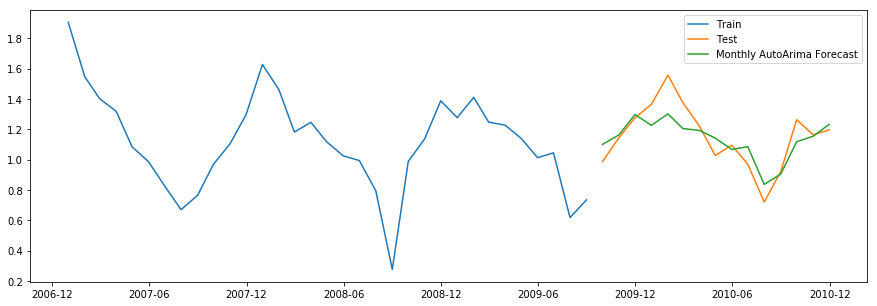

RMSE 0.112952
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   33
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                   5.145
Date:                            Tue, 26 Mar 2019   AIC                             -2.290
Time:                                    12:03:01   BIC                              3.696
Sample:                                         0   HQIC                            -0.276
                                             - 33                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2429      0.099      2.454      0.014       0.049       0.437
ar.L1          0.4899

In [460]:
X = pd.DataFrame(ts_month)

train_size = int(len(X) * 0.7)
train = X.iloc[:train_size]
test = X.iloc[train_size:]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

model = auto_arima(train, trace=True,
                   seasonal=True, m=12,
                   error_action='ignore', suppress_warnings=True)
model.fit(train)

month_forecast = model.predict(n_periods=len(test))
month_forecast = pd.DataFrame(month_forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
pyplot.figure(figsize=(15,5))
pyplot.plot(train)
pyplot.plot(test)
pyplot.plot(month_forecast)
pyplot.legend(['Train','Test','Monthly AutoArima Forecast'], loc=1)
pyplot.show()

rms = sqrt(mean_squared_error(test,month_forecast))
print('RMSE %f' % rms)

print(model.summary())

model2 = auto_arima(X, trace=True,
                   seasonal=True, m=12,
                   error_action='ignore', suppress_warnings=True)

model2 = model2.fit(X)

nex_m = [test.index[-1] + i for i in range(12)]
month_forecast2 = model2.predict(n_periods=len(nex_m))
month_forecast2 = pd.Series(month_forecast2,index = nex_m)

## Holt-Winters

RMSE 0.297286


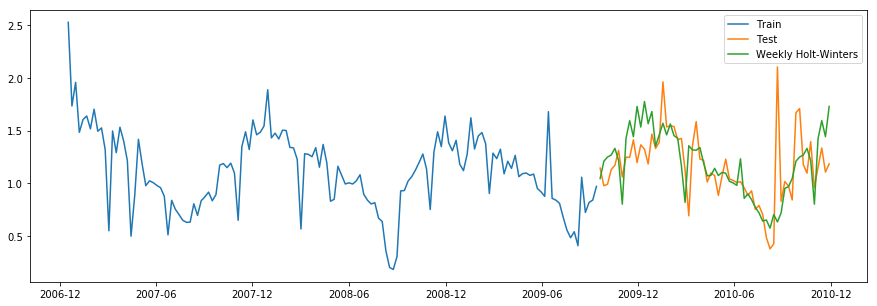

In [462]:
X = pd.DataFrame(ts_week)

train_size = int(len(X) * 0.7)
train = X.iloc[:train_size]
test = X.iloc[train_size:]

model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

pyplot.figure(figsize=(15,5))
pyplot.plot(train.index, train, label='Train')
pyplot.plot(test.index, test, label='Test')
pyplot.plot(pred.index, pred, label='Weekly Holt-Winters')
pyplot.legend(loc=1)

rms = sqrt(mean_squared_error(test,pred))
print('RMSE %f' % rms)

model2 = ExponentialSmoothing(X, seasonal='add', seasonal_periods=52).fit()
pred2 = model2.predict(start=nex[0], end=nex[-1])
week_forecast2_HW = pd.Series(pred2,index = nex)

RMSE 0.143254
None


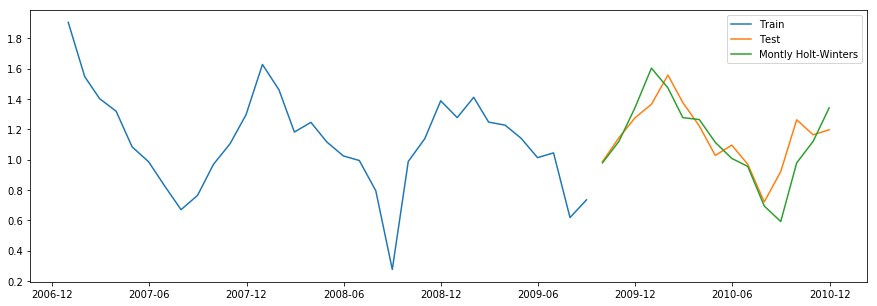

In [463]:
X = pd.DataFrame(ts_month)

train_size = int(len(X) * 0.7)
train = X.iloc[:train_size]
test = X.iloc[train_size:]

model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

pyplot.figure(figsize=(15,5))
pyplot.plot(train.index, train, label='Train')
pyplot.plot(test.index, test, label='Test')
pyplot.plot(pred.index, pred, label='Montly Holt-Winters')
pyplot.legend(loc=1)

rms = sqrt(mean_squared_error(test,pred))
print('RMSE %f' % rms)

print(model.summary())

model2 = ExponentialSmoothing(X, seasonal='add', seasonal_periods=12).fit()
pred2 = model2.predict(start=nex_m[0], end=nex_m[-1])
month_forecast2_HW = pd.Series(pred2,index = nex_m)

## SARIMAX

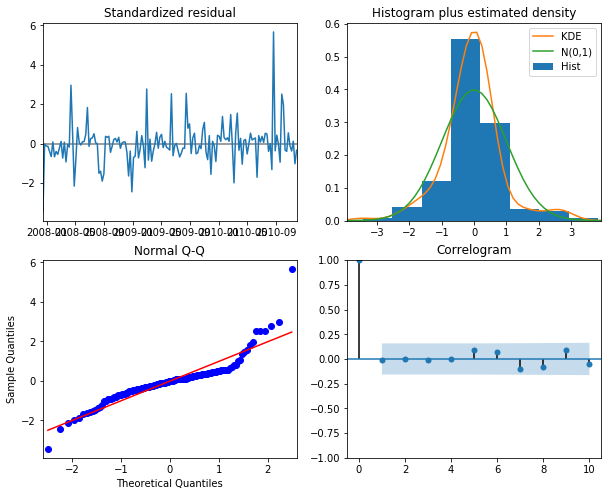

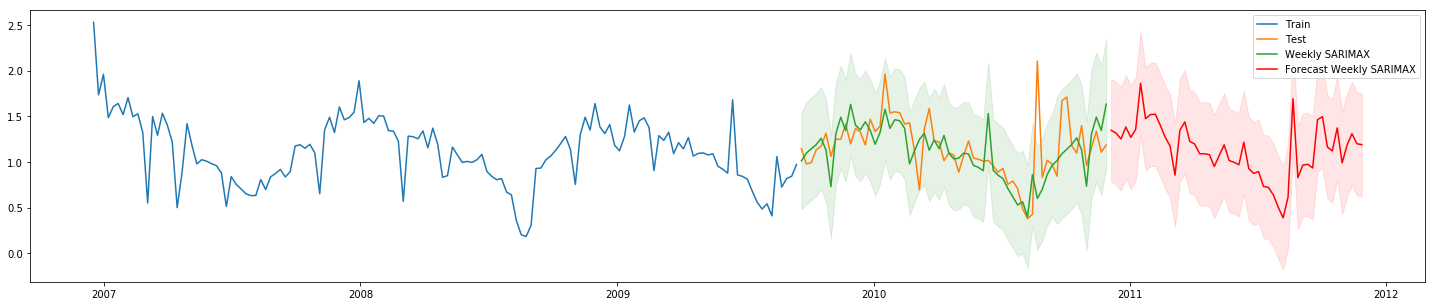

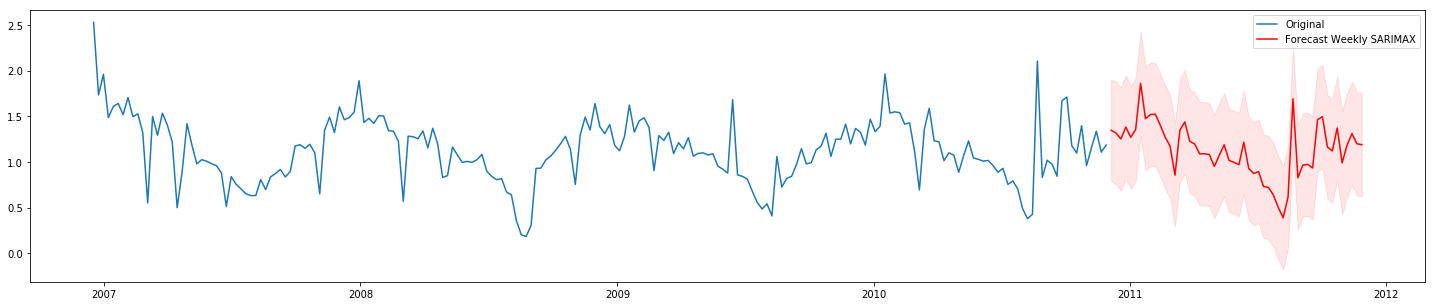

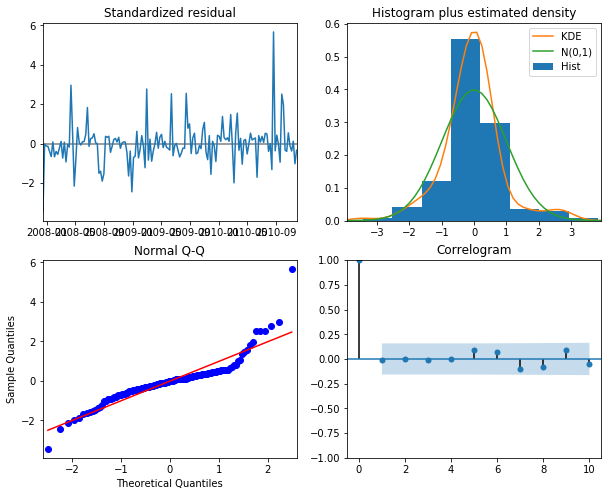

In [536]:
X = pd.DataFrame(ts_week)

train_size = int(len(X) * 0.7)
train = X.iloc[:train_size]
test = X.iloc[train_size:]

my_order = (1, 0, 0)
my_seasonal_order = (1, 1, 0, 52)

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order).fit()
predictions_sarimax = model.get_forecast(steps=round(len(test)))
pred = predictions_sarimax.summary_frame()

model2 = SARIMAX(X, order=my_order, seasonal_order=my_seasonal_order).fit()
predictions_sarimax2 = model2.get_forecast(steps=52)
pred2 = predictions_sarimax2.summary_frame()

#pred = model.predict(start=test.index[0], end=test.index[-1])
#pred = pd.DataFrame(pred,index = test.index,columns=['Prediction'])

pyplot.figure(figsize=(25,5))
pyplot.plot(train.index, train, label='Train')
pyplot.plot(test.index, test, label='Test')
pyplot.plot(pred.index, pred['mean'].values, label='Weekly SARIMAX')
pyplot.fill_between(pred.index,
                    pred['mean_ci_lower'],
                    pred['mean_ci_upper'],
                    color='green', alpha=.1
                   )
pyplot.plot(pred2.index, pred2['mean'].values, color = 'red',label='Forecast Weekly SARIMAX')
pyplot.fill_between(pred2.index,
                    pred2['mean_ci_lower'],
                    pred2['mean_ci_upper'],
                    color='red', alpha=.1
                   )
pyplot.legend(loc=1)

pyplot.figure(figsize=(25,5))
pyplot.plot(ts_week.index, ts_week, label='Original')
pyplot.plot(pred2.index, pred2['mean'].values, color = 'red',label='Forecast Weekly SARIMAX')
pyplot.fill_between(pred2.index,
                    pred2['mean_ci_lower'],
                    pred2['mean_ci_upper'],
                    color='red', alpha=.1
                   )
pyplot.legend(loc=1)

week_sarimax = pd.Series(pred2['mean'].values, index=pred2.index)



model2.plot_diagnostics(figsize=(10,8))

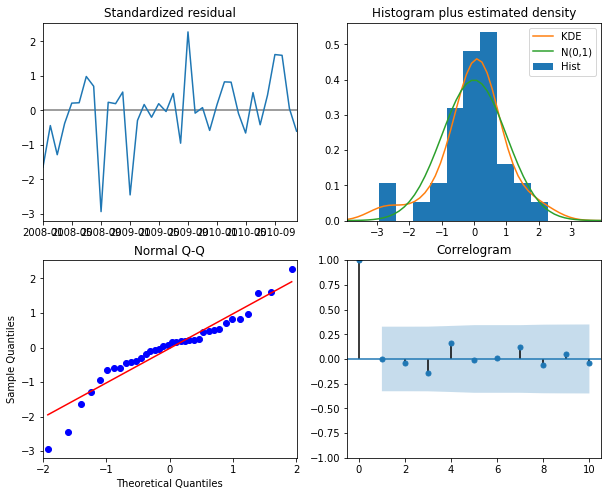

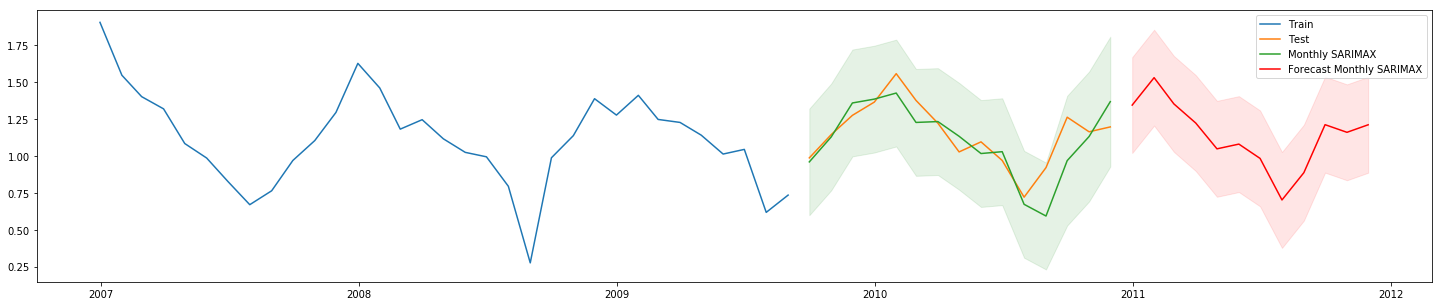

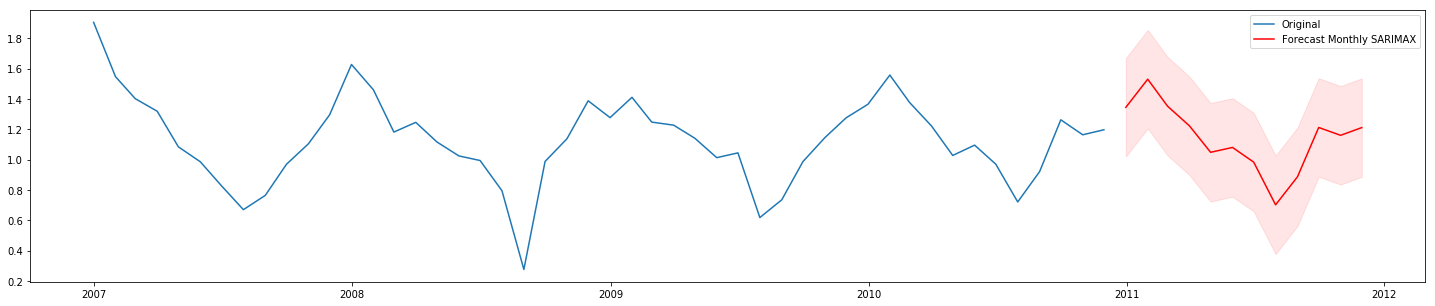

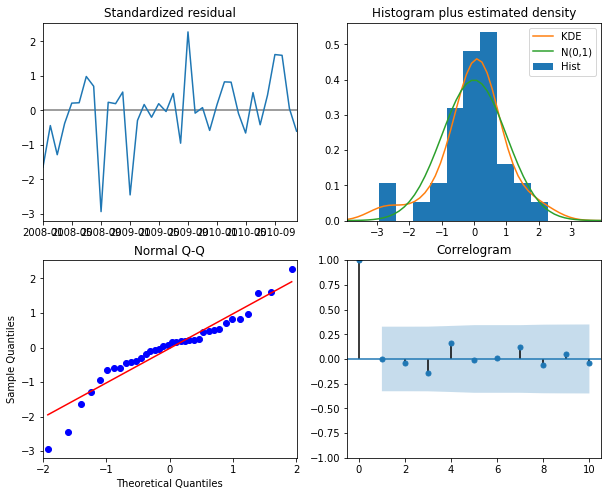

In [540]:
X = pd.DataFrame(ts_month)

train_size = int(len(X) * 0.7)
train = X.iloc[:train_size]
test = X.iloc[train_size:]

my_order = (1, 0, 0)
my_seasonal_order = (1, 1, 0, 12)

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order).fit()
predictions_sarimax = model.get_forecast(steps=round(len(test)))
pred = predictions_sarimax.summary_frame()

model2 = SARIMAX(X, order=my_order, seasonal_order=my_seasonal_order).fit()
predictions_sarimax2 = model2.get_forecast(steps=12)
pred2 = predictions_sarimax2.summary_frame()

#pred = model.predict(start=test.index[0], end=test.index[-1])
#pred = pd.DataFrame(pred,index = test.index,columns=['Prediction'])

pyplot.figure(figsize=(25,5))
pyplot.plot(train.index, train, label='Train')
pyplot.plot(test.index, test, label='Test')
pyplot.plot(pred.index, pred['mean'].values, label='Monthly SARIMAX')
pyplot.fill_between(pred.index,
                    pred['mean_ci_lower'],
                    pred['mean_ci_upper'],
                    color='green', alpha=.1
                   )
pyplot.plot(pred2.index, pred2['mean'].values, color = 'red',label='Forecast Monthly SARIMAX')
pyplot.fill_between(pred2.index,
                    pred2['mean_ci_lower'],
                    pred2['mean_ci_upper'],
                    color='red', alpha=.1
                   )
pyplot.legend(loc=1)

pyplot.figure(figsize=(25,5))
pyplot.plot(ts_month.index, ts_month, label='Original')
pyplot.plot(pred2.index, pred2['mean'].values, color = 'red',label='Forecast Monthly SARIMAX')
pyplot.fill_between(pred2.index,
                    pred2['mean_ci_lower'],
                    pred2['mean_ci_upper'],
                    color='red', alpha=.1
                   )
pyplot.legend(loc=1)

month_sarimax = pd.Series(pred2['mean'].values, index=pred2.index)

model2.plot_diagnostics(figsize=(10,8))

## Comparing Models

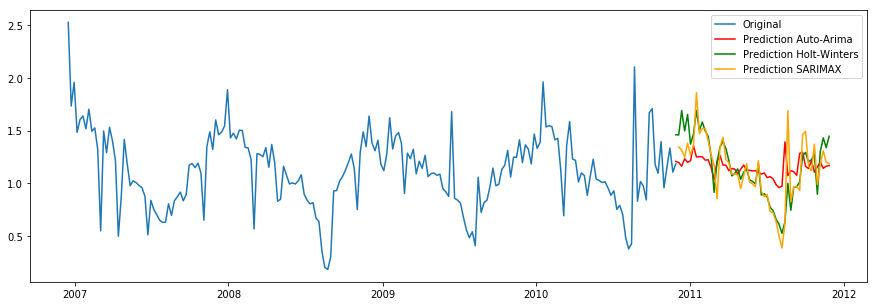

In [467]:
pyplot.figure(figsize=(15,5))
pyplot.plot(ts_week.index, ts_week, label='Original')
pyplot.plot(week_forecast2, label='Prediction Auto-Arima', color='red')
pyplot.plot(week_forecast2_HW, label='Prediction Holt-Winters', color='green')
pyplot.plot(week_sarimax, label='Prediction SARIMAX', color='orange')
pyplot.legend(loc=1)

In [510]:
month_up = []
for i,j in list(zip(month_forecast2_HW.values, np.arange(1.05, 1.35, (1.35-1.05)/len(month_forecast2_HW.values)))):
    month_up.append(i * j)

month_dwn = []
for z,q in list(zip(month_forecast2_HW.values, np.arange(0.95, 0.65, -(0.95-0.65)/len(month_forecast2_HW.values)))):
    month_dwn.append(z * q)

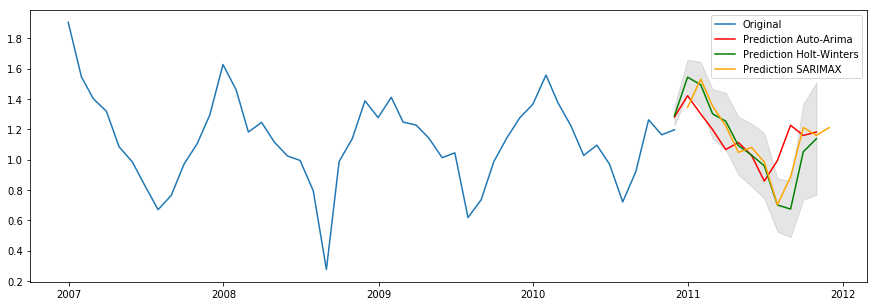

In [511]:
pyplot.figure(figsize=(15,5))
pyplot.plot(ts_month.index, ts_month, label='Original')
pyplot.plot(month_forecast2, label='Prediction Auto-Arima', color='red')
pyplot.plot(month_forecast2_HW, label='Prediction Holt-Winters', color='green')
    
pyplot.fill_between(month_forecast2_HW.index,
                    month_up,
                    month_dwn,
                    alpha=0.1, color='k')

pyplot.plot(month_sarimax, label='Prediction SARIMAX', color='orange')
pyplot.legend(loc=1)

# Dashboard

In [3]:
#https://public.tableau.com/views/ENERGY_15536820743440/Dashboard1?:embed=y&:display_count=yes&publish=yes